In [1]:
import re
import numpy as np

def remove_docstrings(code):
    # 使用正则表达式匹配被 """ 包括的部分，并替换为空字符串
    cleaned_code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    cleaned_code = re.sub(r"'''.*?'''", '', cleaned_code, flags=re.DOTALL)
    return cleaned_code

def cosine_similarity_matrix(nl_features, code_features):
    # 计算每个特征向量的范数
    nl_norms = np.linalg.norm(nl_features, axis=1, keepdims=True)
    code_norms = np.linalg.norm(code_features, axis=1, keepdims=True)
    
    # 计算点积
    dot_product = np.dot(nl_features, code_features.T)
    
    # 计算余弦相似度矩阵
    cosine_similarity = dot_product / (nl_norms * code_norms.T)
    
    return cosine_similarity

In [2]:
def remove_padding_intervals(tokenized_id_data):
    """
    移除 tokenized_id_data 中所有 `[0,0]` 区间（除非它是开头的第一个区间）。

    Args:
    - tokenized_id_data (list of lists): 包含区间的列表，每个区间是一个长度为 2 的列表。

    Returns:
    - filtered_data (list of lists): 移除 `[0,0]` 填充数据后的区间列表。
    """
    if isinstance(tokenized_id_data, np.ndarray):
        tokenized_id_data = tokenized_id_data.tolist()  # 将 NumPy 数组转换为列表
    # 处理的结果列表
    filtered_data = []

    # 保留开头的 `[0,0]` 区间（如果存在）
    if tokenized_id_data and tokenized_id_data[0] == [0,0]:
        filtered_data.append([0,0])
        start_index = 1  # 从第二个元素开始检查
    else:
        start_index = 0

    # 处理剩余的区间
    for interval in tokenized_id_data[start_index:]:
        if interval != [0,0]:  # 仅添加非 `[0,0]` 区间
            filtered_data.append(interval)

    return filtered_data

In [3]:
import json
def load_loss_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return np.array(data)

In [4]:
with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/valid.jsonl", "r") as f:
    comment_dataset = [json.loads(line) for line in f.readlines()]

with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/codebase.jsonl", "r") as f:
    code_dataset = [json.loads(line) for line in f.readlines()]


In [5]:
nl_urls=[]
code_urls=[]
for comment_example in comment_dataset:
    nl_urls.append(comment_example['url'])
    
for code_example in code_dataset:
    code_urls.append(code_example['url'])

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
code_cls_tokens_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/new_valid_code_cls_token_new_align_attention_batch_retrieval.npy'
nl_cls_tokens_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/new_valid_nl_cls_token_new_align_attention_batch_retrieval.npy'

nl_cls_tokens = np.load(nl_cls_tokens_path)
code_cls_tokens = np.load(code_cls_tokens_path)

similarities = cosine_similarity(nl_cls_tokens, code_cls_tokens)

# 为每个comment找到最相似的code，并进行排序
most_similar_code_indices = np.argsort(-similarities, axis=1)  # 降序排序


In [7]:
retri_code_cls_tokens_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/new_valid_code_cls_token_new_batch_retrieval.npy'
retri_nl_cls_tokens_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/new_valid_nl_cls_token_new_batch_retrieval.npy'

retri_nl_cls_tokens = np.load(retri_nl_cls_tokens_path)
retri_code_cls_tokens = np.load(retri_code_cls_tokens_path)

retri_similarities = cosine_similarity(retri_nl_cls_tokens, retri_code_cls_tokens)

# 为每个comment找到最相似的code，并进行排序
retri_most_similar_code_indices = np.argsort(-retri_similarities, axis=1)  # 降序排序

In [8]:
# 假设 most_similar_code_indices 的形状为 (320, n)
retri_num_rows = retri_most_similar_code_indices.shape[0]

retri_ranks=[]

# 遍历每一行，检查前十个值是否包含当前的行索引
for row_idx in range(retri_num_rows):
    rank = 0
    top_10_indices = retri_most_similar_code_indices[row_idx, :1000]  # 获取前十个值
    nl_url = nl_urls[row_idx]  # 当前 comment 的 URL
    matched = False

    # 遍历前十个索引，检查是否有相同的 URL
    for idx in top_10_indices:
        rank+=1
        if code_urls[idx] == nl_url:
            matched = True
            break

    # 输出是否匹配
    if matched:
        retri_ranks.append(1/rank)
        print(f"行 {row_idx} 的前十个最相似代码中包含相同的 URL，排名为 {rank}。")
    else:
        retri_ranks.append(0)

行 0 的前十个最相似代码中包含相同的 URL，排名为 42。
行 1 的前十个最相似代码中包含相同的 URL，排名为 4。
行 2 的前十个最相似代码中包含相同的 URL，排名为 1。
行 4 的前十个最相似代码中包含相同的 URL，排名为 1。
行 5 的前十个最相似代码中包含相同的 URL，排名为 56。
行 7 的前十个最相似代码中包含相同的 URL，排名为 19。
行 8 的前十个最相似代码中包含相同的 URL，排名为 24。
行 9 的前十个最相似代码中包含相同的 URL，排名为 2。
行 10 的前十个最相似代码中包含相同的 URL，排名为 663。
行 11 的前十个最相似代码中包含相同的 URL，排名为 313。
行 12 的前十个最相似代码中包含相同的 URL，排名为 1。
行 13 的前十个最相似代码中包含相同的 URL，排名为 1。
行 14 的前十个最相似代码中包含相同的 URL，排名为 6。
行 15 的前十个最相似代码中包含相同的 URL，排名为 1。
行 19 的前十个最相似代码中包含相同的 URL，排名为 720。
行 20 的前十个最相似代码中包含相同的 URL，排名为 5。
行 21 的前十个最相似代码中包含相同的 URL，排名为 1。
行 22 的前十个最相似代码中包含相同的 URL，排名为 1。
行 23 的前十个最相似代码中包含相同的 URL，排名为 23。
行 24 的前十个最相似代码中包含相同的 URL，排名为 39。
行 25 的前十个最相似代码中包含相同的 URL，排名为 142。
行 26 的前十个最相似代码中包含相同的 URL，排名为 1。
行 27 的前十个最相似代码中包含相同的 URL，排名为 7。
行 28 的前十个最相似代码中包含相同的 URL，排名为 64。
行 29 的前十个最相似代码中包含相同的 URL，排名为 3。
行 30 的前十个最相似代码中包含相同的 URL，排名为 1。
行 31 的前十个最相似代码中包含相同的 URL，排名为 1。
行 32 的前十个最相似代码中包含相同的 URL，排名为 574。
行 33 的前十个最相似代码中包含相同的 URL，排名为 52。
行 34 的前十个最相似代码中包含相同的 URL，排名为 1。
行 35 的前十个最相似代码中包含相同的 URL，排名为 1

In [9]:
# 假设 most_similar_code_indices 的形状为 (320, n)
num_rows = most_similar_code_indices.shape[0]

ranks=[]

# 遍历每一行，检查前十个值是否包含当前的行索引
for row_idx in range(num_rows):
    rank = 0
    top_10_indices = most_similar_code_indices[row_idx, :1000]  # 获取前十个值
    nl_url = nl_urls[row_idx]  # 当前 comment 的 URL
    matched = False

    # 遍历前十个索引，检查是否有相同的 URL
    for idx in top_10_indices:
        rank+=1
        if code_urls[idx] == nl_url:
            matched = True
            break

    # 输出是否匹配
    if matched:
        ranks.append(1/rank)
        print(f"行 {row_idx} 的前十个最相似代码中包含相同的 URL，排名为 {rank}。")
    else:
        ranks.append(0)


行 0 的前十个最相似代码中包含相同的 URL，排名为 40。
行 1 的前十个最相似代码中包含相同的 URL，排名为 26。
行 2 的前十个最相似代码中包含相同的 URL，排名为 1。
行 3 的前十个最相似代码中包含相同的 URL，排名为 19。
行 4 的前十个最相似代码中包含相同的 URL，排名为 81。
行 5 的前十个最相似代码中包含相同的 URL，排名为 346。
行 7 的前十个最相似代码中包含相同的 URL，排名为 52。
行 9 的前十个最相似代码中包含相同的 URL，排名为 7。
行 10 的前十个最相似代码中包含相同的 URL，排名为 1。
行 12 的前十个最相似代码中包含相同的 URL，排名为 50。
行 13 的前十个最相似代码中包含相同的 URL，排名为 1。
行 14 的前十个最相似代码中包含相同的 URL，排名为 34。
行 15 的前十个最相似代码中包含相同的 URL，排名为 1。
行 18 的前十个最相似代码中包含相同的 URL，排名为 136。
行 19 的前十个最相似代码中包含相同的 URL，排名为 65。
行 20 的前十个最相似代码中包含相同的 URL，排名为 328。
行 21 的前十个最相似代码中包含相同的 URL，排名为 2。
行 22 的前十个最相似代码中包含相同的 URL，排名为 1。
行 23 的前十个最相似代码中包含相同的 URL，排名为 15。
行 24 的前十个最相似代码中包含相同的 URL，排名为 409。
行 25 的前十个最相似代码中包含相同的 URL，排名为 9。
行 26 的前十个最相似代码中包含相同的 URL，排名为 5。
行 27 的前十个最相似代码中包含相同的 URL，排名为 143。
行 28 的前十个最相似代码中包含相同的 URL，排名为 14。
行 29 的前十个最相似代码中包含相同的 URL，排名为 1。
行 30 的前十个最相似代码中包含相同的 URL，排名为 1。
行 31 的前十个最相似代码中包含相同的 URL，排名为 1。
行 32 的前十个最相似代码中包含相同的 URL，排名为 258。
行 33 的前十个最相似代码中包含相同的 URL，排名为 2。
行 34 的前十个最相似代码中包含相同的 URL，排名为 1。
行 35 的前十个最相似代码中包含相同的 URL，排

In [10]:
np.mean(ranks)

0.37130513583867203

In [11]:
np.mean(retri_ranks)

0.43967581663061844

In [12]:
# 计算增加和减小的差值，并存储索引和值的元组
increase_diff = [(i, retri_ranks[i] - ranks[i]) for i in range(len(retri_ranks))]
decrease_diff = [(i, ranks[i] - retri_ranks[i]) for i in range(len(retri_ranks))]

# 对增加和减小的差值进行排序，并分别取前五名
top_5_increase = sorted(increase_diff, key=lambda x: x[1], reverse=True)[:5]
top_5_decrease = sorted(decrease_diff, key=lambda x: x[1], reverse=True)[:200]

# 输出结果
print("增加最大的前五名索引和差值:")
for idx, diff in top_5_increase:
    print(f"Index: {idx}, Difference: {diff}, retri_rank: {diff}, rank: {diff}")

print("\n减小最大的前五名索引和差值:")
for idx, diff in top_5_decrease:
    print(f"Index: {idx}, Difference: {diff}")

增加最大的前五名索引和差值:
Index: 124, Difference: 1.0, retri_rank: 1.0, rank: 1.0
Index: 592, Difference: 1.0, retri_rank: 1.0, rank: 1.0
Index: 1082, Difference: 1.0, retri_rank: 1.0, rank: 1.0
Index: 1086, Difference: 1.0, retri_rank: 1.0, rank: 1.0
Index: 1740, Difference: 1.0, retri_rank: 1.0, rank: 1.0

减小最大的前五名索引和差值:
Index: 1920, Difference: 1.0
Index: 3636, Difference: 1.0
Index: 5783, Difference: 1.0
Index: 6533, Difference: 1.0
Index: 7127, Difference: 1.0
Index: 7586, Difference: 1.0
Index: 7619, Difference: 1.0
Index: 7626, Difference: 1.0
Index: 8980, Difference: 1.0
Index: 9479, Difference: 1.0
Index: 10078, Difference: 1.0
Index: 10355, Difference: 1.0
Index: 10995, Difference: 1.0
Index: 11648, Difference: 1.0
Index: 12652, Difference: 1.0
Index: 7659, Difference: 0.9988826815642458
Index: 5240, Difference: 0.9988726042841037
Index: 10774, Difference: 0.99880810488677
Index: 8002, Difference: 0.9987228607918263
Index: 3768, Difference: 0.9987012987012988
Index: 10, Difference: 0.99

In [13]:
# 统计 difference 大于 0 的元素数量
count_greater_than_zero = sum(1 for _, diff in increase_diff if diff > 0)

# 输出结果
print(f"大于 0 的元素个数: {count_greater_than_zero}")

大于 0 的元素个数: 6127


In [14]:
# 统计 difference 大于 0 的元素数量
count_greater_than_zero = sum(1 for _, diff in increase_diff if diff < 0)

# 输出结果
print(f"大于 0 的元素个数: {count_greater_than_zero}")

大于 0 的元素个数: 4119


In [643]:
mrr_index = 1086  
print(most_similar_code_indices[mrr_index][:10])
print(similarities[mrr_index][most_similar_code_indices[mrr_index][:10]])
print(np.max(similarities[mrr_index]), np.min(similarities[mrr_index]))

print(retri_most_similar_code_indices[mrr_index][:10])
print(retri_similarities[mrr_index][retri_most_similar_code_indices[mrr_index][:10]])
print(np.max(retri_similarities[mrr_index]), np.min(retri_similarities[mrr_index]))

[42866 28404 43348 42210  2643 15962  4387 30664  8453 22794]
[0.6950618  0.6881165  0.687628   0.68701506 0.6859775  0.6800636
 0.6785715  0.675372   0.67074287 0.6688465 ]
0.6950618 -0.21650887
[ 6625 16944 13511  3690 13557 22077 42746 23529 30591 10907]
[0.76155806 0.7226049  0.6969614  0.6968601  0.6927304  0.68961686
 0.68934965 0.6883421  0.6849847  0.6847403 ]
0.76155806 -0.012936693


In [747]:
import json
import os

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/valid_tokenized_code_tokens.json'


# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    code_tokens_data = json.load(f)

In [748]:
# code_ind = 4148
# comment_ind = 3081

In [749]:
code_ind = 6625
comment_ind = 1086

In [750]:
comment_id = comment_ind

In [751]:
code_data = code_tokens_data[code_ind]

In [752]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/code_labels/'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 遍历列表的每一项
for i, token_list in enumerate(code_data):
   
    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i}.txt')
    
    # 保存到文件中
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        f_out.write(str(code_data[i]))
    # 找到</s>的位置，并保留其之前的部分
    if '</s>' == token_list:
        code_length = i
        break

print("处理完成！")

处理完成！


In [753]:
output_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/comment_labels/'

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

comment_data = ['<s>'] + comment_dataset[comment_id]["docstring_tokens"] + ['</s>']
# 遍历列表的每一项
for i, token_list in enumerate(comment_data):
   
    # 生成输出文件路径
    output_file_path = os.path.join(output_dir, f'text_{i}.txt')
    
    # 保存到文件中
    with open(output_file_path, 'w', encoding='utf-8') as f_out:
        f_out.write(comment_data[i])
    # 找到</s>的位置，并保留其之前的部分
    if '</s>' == token_list:
        break

print("处理完成！")

处理完成！


In [754]:
import numpy as np

# 文件路径
nl_tokens_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/new_valid_nl_tokens_new_align_attention_batch_retrieval.npy'
code_tokens_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/new_valid_code_tokens_new_align_attention_batch_retrieval.npy'
output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/train_data.npy'

# 获取 n 和 m
n = len(comment_data)
m = code_length

# 读取nl_tokens.npy中的前n条数据
nl_tokens = np.load(nl_tokens_path)[comment_ind][:n]

# 读取code_tokens.npy中的前m条数据
code_tokens = np.load(code_tokens_path)[0][:m]

# 拼接两部分数据
combined_data = np.concatenate((nl_tokens, code_tokens))
print(combined_data.shape)

# 将拼接后的数据保存到train_data.npy
np.save(output_path, combined_data)

print(f"拼接完成！数据已保存到 {output_path}")


(177, 768)
拼接完成！数据已保存到 /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/train_data.npy


In [755]:
import json

# 文件路径
index_output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/code_index.json'
index_output_path_2 = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_2/code_index.json'

# 生成从0到n+m-1的索引
indices = list(range(m))

# 将索引保存到index.json中
with open(index_output_path, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

print(f"索引已保存到 {index_output_path}")

with open(index_output_path_2, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

print(f"索引已保存到 {index_output_path_2}")


索引已保存到 /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/code_index.json
索引已保存到 /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_2/code_index.json


In [756]:
# 文件路径
comment_index_output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/comment_index.json'
comment_index_output_path_2 = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_2/comment_index.json'

# 生成从0到n+m-1的索引
indices = list(range(n))

# 将索引保存到index.json中
with open(comment_index_output_path, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

print(f"索引已保存到 {comment_index_output_path}")

# 将索引保存到index.json中
with open(comment_index_output_path_2, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

print(f"索引已保存到 {comment_index_output_path_2}")

索引已保存到 /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/comment_index.json
索引已保存到 /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_2/comment_index.json


In [757]:
# 文件路径
all_index_output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/index.json'
all_index_output_path_2 = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_2/index.json'

# 生成从0到n+m-1的索引
indices = list(range(len(combined_data)))

# 将索引保存到index.json中
with open(all_index_output_path, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

print(f"索引已保存到 {all_index_output_path}")

# 将索引保存到index.json中
with open(all_index_output_path_2, 'w', encoding='utf-8') as f_out:
    json.dump(indices, f_out, ensure_ascii=False, indent=4)

print(f"索引已保存到 {all_index_output_path_2}")

索引已保存到 /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/index.json
索引已保存到 /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_2/index.json


In [758]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import umap


# 读取高维向量 (num, 768)
input_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/train_data.npy'
data = np.load(input_path)

# 使用UMAP进行降维到二维
umap_model = umap.UMAP(n_components=2)
embedding = umap_model.fit_transform(data)

# 将降维后的结果保存到embedding.npy文件中
output_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/embedding.npy'
np.save(output_path, embedding)

print(f"Embedding saved to {output_path}")


Embedding saved to /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/embedding.npy


In [782]:
all_nodes_2d = embedding  # 使用你降维后的二维数据

x_min, y_min = np.min(all_nodes_2d, axis=0)
x_max, y_max = np.max(all_nodes_2d, axis=0)
# ebd_extent = ebd_max - ebd_min
x_extent = x_max - x_min
y_extent = y_max - y_min

x_min = x_min - 0.3 * x_extent
x_max = x_max + 0.3 * x_extent
y_min = y_min - 0.3 * y_extent
y_max = y_max + 0.3 * y_extent

# x_min = min(x_min, y_min)
# y_min = min(x_min, y_min)
# x_max = max(x_max, y_max)
# y_max = max(x_max, y_max)


# 打印结果
print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")

# 将结果保存到指定文件夹
save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1'
scale_path = os.path.join(save_dir, "scale.npy")
np.save(scale_path, [x_min, y_min, x_max, y_max])

print(f"Scale saved to {scale_path}")

x_min: -3.2467794597148893, x_max: 14.912050533294678, y_min: -2.765681931376457, y_max: 12.574761295318604
Scale saved to /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/scale.npy


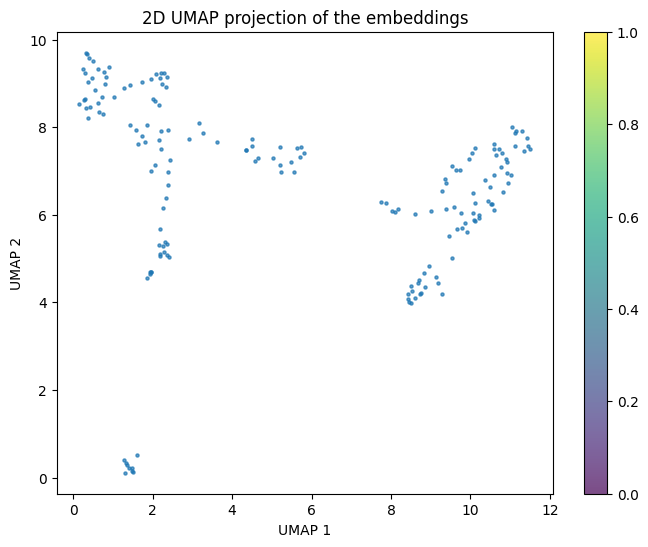

Embedding saved to /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/embedding.npy


In [760]:
import matplotlib.pyplot as plt

# 可视化 embedding 的二维散点图
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', alpha=0.7)
plt.title('2D UMAP projection of the embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()

print(f"Embedding saved to {output_path}")

In [761]:
import numpy as np
import json
import os
from sklearn.metrics.pairwise import cosine_similarity

# 读取数据
data_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/train_data.npy'
data = np.load(data_path)

# 读取 comment token 长度
comment_index_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/comment_index.json'
with open(comment_index_path, 'r') as f:
    comment_length = len(json.load(f))

# 拆分 data 成 comment 和 code token
comments = data[:comment_length]
code_tokens = data[comment_length:]

# 计算相似度函数（使用余弦相似度）
def compute_similarity(tokens_a, tokens_b):
    return cosine_similarity(tokens_a, tokens_b)

# intra 相似度计算
intra_comment_sim = compute_similarity(comments, comments)
intra_code_sim = compute_similarity(code_tokens, code_tokens)

# inter 相似度计算
inter_comment_code_sim = compute_similarity(comments, code_tokens)
inter_code_comment_sim = compute_similarity(code_tokens, comments)

# 获取前 k 个最近邻
k = 11  # 假设我们需要前 5 个最近邻
def get_top_k_indices(sim_matrix, k):
    return np.argsort(-sim_matrix, axis=1)[:, :k]  # 获取前 k 个索引

# intra 计算
intra_comment_neighbors = get_top_k_indices(intra_comment_sim, k)
intra_code_neighbors = get_top_k_indices(intra_code_sim, k) + comment_length  # 加 offset

# inter 计算
inter_comment_neighbors = get_top_k_indices(inter_comment_code_sim, k) + comment_length  # comment 对 code 的相似度
inter_code_neighbors = get_top_k_indices(inter_code_comment_sim, k)  # code 对 comment 的相似度

# 拼接 intra 和 inter 结果
intra_neighbors = np.concatenate([intra_comment_neighbors, intra_code_neighbors], axis=0)
inter_neighbors = np.concatenate([inter_comment_neighbors, inter_code_neighbors], axis=0)


In [762]:

# 保存结果到文件
save_dir = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1'
intra_path = os.path.join(save_dir, "intra_similarity.npy")
inter_path = os.path.join(save_dir, "inter_similarity.npy")

np.save(intra_path, intra_neighbors)
np.save(inter_path, inter_neighbors)

print(f"Intra neighbors saved to {intra_path}")
print(f"Inter neighbors saved to {inter_path}")


Intra neighbors saved to /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/intra_similarity.npy
Inter neighbors saved to /home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/inter_similarity.npy


In [763]:
ori_valid_code_attention_output_path = os.path.join("/home/yiming/cophi/training_dynamic/gcb_tokens_temp", 'new_valid_code_attention_new_align_attention_batch_retrieval.npy')
ori_valid_nl_attention_output_path = os.path.join("/home/yiming/cophi/training_dynamic/gcb_tokens_temp", 'new_valid_nl_attention_new_align_attention_batch_retrieval.npy')
ori_valid_code_attention_feature = np.load(ori_valid_code_attention_output_path)
ori_valid_nl_attention_feature = np.load(ori_valid_nl_attention_output_path)

In [764]:
j = comment_id

In [765]:
top_n = 10  # 查找值最高的前10个索引

# 获取第 i 个数组
array = ori_valid_nl_attention_feature[j]

# 使用 argsort 获取值从大到小排序的索引
top_indices = np.argsort(array)[-top_n:][::-1]

# 打印值最高的10个索引
# print("值最高的10个索引:", top_indices)
# print("对应的值:", array[top_indices])
token_list1 = comment_dataset[j]["docstring_tokens"][:]
print(comment_dataset[j]["docstring"])

Return a new datetime with new values for the specified fields.


In [766]:
array = array[1:]

In [767]:
from IPython.display import display, HTML
normalized_contributions = (array - array.min()) / (array.max() - array.min())
html_string = "<p>"

indices = list(range(1, len(ori_valid_nl_attention_feature[j])))

# 为每个token设置颜色
for idx, token in zip(indices, token_list1):
    # print(idx, token)
    color_intensity = int(255 * (1 - normalized_contributions[idx-1]))  # 将贡献值转为颜色强度
    color = f"rgb({color_intensity}, {color_intensity}, 255)"  # 颜色从浅蓝到深蓝
    html_string += f'<span style="background-color: {color};">{token} </span>'

html_string += "</p>"

# 在Jupyter Notebook中显示带有颜色标记的文本
display(HTML(html_string))

In [768]:
tokenized_id_path = os.path.join("/home/yiming/cophi/training_dynamic/graphcodebert/Epoch_1", 'tokenized_id_valid.json')
tokenized_id_data = load_loss_data(tokenized_id_path)

In [769]:
# 使用函数
# filtered_data = remove_padding_intervals(tokenized_id_data[code_ind])
filtered_data = remove_padding_intervals(tokenized_id_data[0])
print(filtered_data)

[[0, 0], [0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [17, 18], [18, 19], [19, 20], [20, 21], [21, 22], [22, 23], [23, 24], [24, 25], [25, 26], [26, 27], [27, 28], [28, 29], [29, 31], [31, 32], [32, 33], [33, 34], [34, 37], [37, 38], [38, 39], [39, 40], [40, 41], [41, 42], [42, 43], [43, 44], [44, 45], [45, 46], [46, 47], [47, 48], [48, 49], [49, 50], [50, 51], [51, 52], [52, 53], [53, 54], [54, 55], [55, 56], [56, 57], [57, 58], [58, 59], [59, 60], [60, 61], [61, 62], [62, 63], [63, 64], [64, 65], [65, 66], [66, 67], [67, 68], [68, 69], [69, 70], [70, 71], [71, 72], [72, 73], [73, 74], [74, 75], [75, 76], [76, 77], [77, 78], [78, 79], [79, 80], [80, 81], [81, 82], [82, 83], [83, 84], [84, 85], [85, 86], [86, 87], [87, 88], [88, 89], [89, 90], [90, 91], [91, 92], [92, 93], [93, 94], [94, 95], [95, 96], [96, 97], [97, 98], [98, 99], [99, 100], [100, 101], [101, 102], [102, 104], [10

In [770]:
# 创建一个新的数组用于存储修改后的特征
new_ori_code_attention_feature = np.zeros(ori_valid_code_attention_feature[code_ind].shape[0])

# 遍历每个区间
for num, (start, end) in enumerate(filtered_data):
    if end > start:
        # 计算该区间内的行的平均值
        mean_values = np.mean(ori_valid_code_attention_feature[code_ind][start+1:end+1], axis=0)
        # 将平均值存储在新的数组的相应行
        new_ori_code_attention_feature[num] = mean_values
    else:
        new_ori_code_attention_feature[num] = ori_valid_code_attention_feature[code_ind][end]

In [771]:
top_n = 10  # 查找值最高的前10个索引

k = code_ind
# 获取第 i 个数组
code_array = new_ori_code_attention_feature

# 使用 argsort 获取值从大到小排序的索引
code_top_indices = np.argsort(code_array)[-top_n:][::-1]

# 打印值最高的10个索引
print("值最高的10个索引:", code_top_indices)
print("对应的值:", code_array[code_top_indices])
# token_list2 = train_data[k]["docstring_tokens"]
# print(token_list2)
token_list2 = code_dataset[code_ind]["code_tokens"][:]

值最高的10个索引: [  2  28  21  27 120  47   7  67  65  12]
对应的值: [0.01929665 0.01893968 0.01836783 0.01732922 0.01731105 0.01694616
 0.01692181 0.01662359 0.01628963 0.01596519]


In [772]:
code_array = np.nan_to_num(code_array, nan=0.0)

In [773]:
code_array = code_array[1:]
from collections import deque
code_normalized_contributions = (code_array - code_array.min()) / (code_array.max() - code_array.min())
html_string = "<pre>"

indices = list(range(1, len(new_ori_code_attention_feature)))
code_snippet = remove_docstrings(code_dataset[code_ind]["code"])

tokens_with_contributions = deque(zip(token_list2, code_normalized_contributions))

buffer = ""

# 遍历原始代码片段的每个字符
for char in code_snippet:
    if tokens_with_contributions:
        token, contrib = tokens_with_contributions[0]
        buffer += char

        # 检查缓冲区是否匹配当前 token
        if buffer == token:
            color_intensity = int(255 * (1 - contrib))  # 将贡献值转为颜色强度
            color = f"rgb({color_intensity}, {color_intensity}, 255)"  # 颜色从浅蓝到深蓝
            html_string += f'<span style="background-color: {color};">{buffer}</span>'
            buffer = ""  # 清空缓冲区
            tokens_with_contributions.popleft()  # 移除已匹配的 token
        elif not token.startswith(buffer):
            # 如果当前缓冲区不匹配 token，则将缓冲区内容添加到 HTML 并清空缓冲区
            html_string += buffer[0]
            buffer = buffer[1:]
    else:
        html_string += char

html_string += buffer  # 添加剩余的缓冲区内容

html_string += "</pre>"

# 在Jupyter Notebook中显示带有颜色标记的文本
display(HTML(html_string))

In [774]:
comment_sorted_indices = np.argsort(-intra_comment_sim)
# 遍历每一行的排序索引，并输出排序后的 comment_data
for row_idx, sorted_indices in enumerate(comment_sorted_indices):
    sorted_comments = [comment_data[i] for i in sorted_indices]
    sorted_similarities = [intra_comment_sim[row_idx][i] for i in sorted_indices]
    print(f"Row {comment_data[row_idx]} most similar comments:")
    for idx, (comment, similarity) in enumerate(zip(sorted_comments, sorted_similarities)):
        print(f"  Rank {idx + 1}: {comment} (Similarity: {similarity:.4f})")
    print()  # 空行用于分隔每一行的输出

Row <s> most similar comments:
  Rank 1: <s> (Similarity: 1.0000)
  Rank 2: with (Similarity: 0.6547)
  Rank 3: new (Similarity: 0.6356)
  Rank 4: values (Similarity: 0.5540)
  Rank 5: </s> (Similarity: 0.5452)
  Rank 6: specified (Similarity: 0.5277)
  Rank 7: the (Similarity: 0.5096)
  Rank 8: datetime (Similarity: 0.5080)
  Rank 9: fields (Similarity: 0.4988)
  Rank 10: . (Similarity: 0.4836)
  Rank 11: a (Similarity: 0.4804)
  Rank 12: for (Similarity: 0.4767)
  Rank 13: new (Similarity: 0.4383)
  Rank 14: Return (Similarity: 0.3789)

Row Return most similar comments:
  Rank 1: Return (Similarity: 1.0000)
  Rank 2: a (Similarity: 0.9568)
  Rank 3: new (Similarity: 0.9456)
  Rank 4: datetime (Similarity: 0.8686)
  Rank 5: with (Similarity: 0.5994)
  Rank 6: <s> (Similarity: 0.3789)
  Rank 7: new (Similarity: 0.0065)
  Rank 8: values (Similarity: -0.0689)
  Rank 9: specified (Similarity: -0.1920)
  Rank 10: fields (Similarity: -0.1962)
  Rank 11: </s> (Similarity: -0.2106)
  Rank 12:

In [775]:
code_sorted_indices = np.argsort(-intra_code_sim)
# 遍历每一行的排序索引，并输出排序后的 code_data
for row_idx, sorted_indices in enumerate(code_sorted_indices):
    sorted_code = [code_data[i] for i in sorted_indices]
    sorted_similarities = [intra_code_sim[row_idx][i] for i in sorted_indices]
    print(f"Row {code_data[row_idx]} most similar codes:")
    for idx, (comment, similarity) in enumerate(zip(sorted_code, sorted_similarities)):
        print(f"  Rank {idx + 1}: {comment} (Similarity: {similarity:.4f})")
    print()  # 空行用于分隔每一行的输出

Row <s> most similar codes:
  Rank 1: <s> (Similarity: 1.0000)
  Rank 2: Ġ= (Similarity: 0.7103)
  Rank 3: Ġself (Similarity: 0.7100)
  Rank 4: Ġself (Similarity: 0.7015)
  Rank 5: ĠNone (Similarity: 0.6969)
  Rank 6: Ġ. (Similarity: 0.6937)
  Rank 7: Ġself (Similarity: 0.6922)
  Rank 8: Ġ, (Similarity: 0.6900)
  Rank 9: Ġ= (Similarity: 0.6899)
  Rank 10: Ġ. (Similarity: 0.6849)
  Rank 11: Ġ. (Similarity: 0.6846)
  Rank 12: Ġ, (Similarity: 0.6836)
  Rank 13: Ġself (Similarity: 0.6801)
  Rank 14: Ġ, (Similarity: 0.6726)
  Rank 15: ĠNone (Similarity: 0.6718)
  Rank 16: Ġ, (Similarity: 0.6713)
  Rank 17: ĠNone (Similarity: 0.6706)
  Rank 18: Ġ= (Similarity: 0.6703)
  Rank 19: Ġ. (Similarity: 0.6692)
  Rank 20: ĠNone (Similarity: 0.6684)
  Rank 21: ĠNone (Similarity: 0.6679)
  Rank 22: Ġself (Similarity: 0.6678)
  Rank 23: ĠNone (Similarity: 0.6658)
  Rank 24: Ġ= (Similarity: 0.6657)
  Rank 25: ĠNone (Similarity: 0.6629)
  Rank 26: Ġ= (Similarity: 0.6619)
  Rank 27: Ġ= (Similarity: 0.6609)


  Rank 59: Ġmonth (Similarity: 0.5341)
  Rank 60: Ġ, (Similarity: 0.5314)
  Rank 61: Ġmonth (Similarity: 0.5289)
  Rank 62: Ġ) (Similarity: 0.5223)
  Rank 63: Ġday (Similarity: 0.5083)
  Rank 64: Ġminute (Similarity: 0.4913)
  Rank 65: Ġif (Similarity: 0.4886)
  Rank 66: Ġself (Similarity: 0.4880)
  Rank 67: Ġif (Similarity: 0.4771)
  Rank 68: ĠTrue (Similarity: 0.4730)
  Rank 69: Ġ( (Similarity: 0.4060)
  Rank 70: Ġhour (Similarity: 0.3971)
  Rank 71: Ġhour (Similarity: 0.3686)
  Rank 72: Ġ( (Similarity: 0.3566)
  Rank 73: Ġ, (Similarity: 0.3411)
  Rank 74: Ġsecond (Similarity: 0.3339)
  Rank 75: Ġday (Similarity: 0.3327)
  Rank 76: Ġ. (Similarity: 0.3030)
  Rank 77: etime (Similarity: 0.2921)
  Rank 78: second (Similarity: 0.2869)
  Rank 79: Ġminute (Similarity: 0.2717)
  Rank 80: Ġif (Similarity: 0.2701)
  Rank 81: __ (Similarity: 0.2572)
  Rank 82: Ġmicro (Similarity: 0.2527)
  Rank 83: Ġif (Similarity: 0.2397)
  Rank 84: Ġ. (Similarity: 0.2192)
  Rank 85: Ġmonth (Similarity: 0.19

In [776]:
inter_comment_code_sim.shape

(14, 163)

In [777]:
print(np.max(inter_comment_code_sim))  # 输出最大值
print(np.min(inter_comment_code_sim))  # 输出最小值

0.72310936
-0.51619196


In [778]:
print(np.max(intra_comment_sim))
print(np.min(intra_comment_sim))

1.0000004
-0.23173913


In [779]:
print(np.max(intra_code_sim))
print(np.min(intra_code_sim))

1.0000006
-0.23064977


In [780]:
comment_sorted_indices = np.argsort(-inter_comment_code_sim)
# 遍历每一行的排序索引，并输出排序后的 comment_data
for row_idx, sorted_indices in enumerate(comment_sorted_indices):
    sorted_comments = [code_data[i] for i in sorted_indices]
    sorted_similarities = [inter_comment_code_sim[row_idx][i] for i in sorted_indices]
    print(f"Row {comment_data[row_idx]} most similar codes:")
    for idx, (comment, similarity) in enumerate(zip(sorted_comments, sorted_similarities)):
        print(f"  Rank {idx + 1}: {comment} (Similarity: {similarity:.4f})")
    print()  # 空行用于分隔每一行的输出

Row <s> most similar codes:
  Rank 1: <s> (Similarity: 0.4839)
  Rank 2: Ġ( (Similarity: 0.4428)
  Rank 3: Ġ. (Similarity: 0.3782)
  Rank 4: __ (Similarity: 0.3704)
  Rank 5: etime (Similarity: 0.3615)
  Rank 6: Ġ, (Similarity: 0.3513)
  Rank 7: Ġ( (Similarity: 0.3469)
  Rank 8: Ġ) (Similarity: 0.3449)
  Rank 9: Ġ, (Similarity: 0.3383)
  Rank 10: new (Similarity: 0.3369)
  Rank 11: Ġ, (Similarity: 0.3298)
  Rank 12: Ġself (Similarity: 0.3278)
  Rank 13: Ġ, (Similarity: 0.3230)
  Rank 14: Ġ= (Similarity: 0.3196)
  Rank 15: Ġ= (Similarity: 0.3054)
  Rank 16: Ġself (Similarity: 0.2805)
  Rank 17: Ġself (Similarity: 0.2746)
  Rank 18: Ġ, (Similarity: 0.2678)
  Rank 19: ĠNone (Similarity: 0.2637)
  Rank 20: Ġ__ (Similarity: 0.2631)
  Rank 21: Ġ, (Similarity: 0.2589)
  Rank 22: Ġ. (Similarity: 0.2582)
  Rank 23: Ġ, (Similarity: 0.2567)
  Rank 24: ĠNone (Similarity: 0.2555)
  Rank 25: ĠNone (Similarity: 0.2522)
  Rank 26: Ġ= (Similarity: 0.2456)
  Rank 27: Ġ. (Similarity: 0.2432)
  Rank 28: Ġ